# **Image Classification: A Comparison of Manhattan (L1) and Euclidean (L2) Distances with 5-fold Cross-Validation**


**Extract Dataset: Unzip the ZIP File**

In [ ]:
import zipfile, os

zip_path = "/content/animal_dataset.zip"
extract_path = "/content/animal_dataset"

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_path)

print("Dataset extracted under:", extract_path)
print(os.listdir(extract_path))

Dataset extracted under: /content/animal_dataset
['animal_dataset']


**Import Required Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random, os

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

random.seed(42)
np.random.seed(42)

**Load Dataset Grayscale 32×32 Images**

In [ ]:
DATASET_DIR = "/content/animal_dataset/animal_dataset"

def load_dataset(path, size=(32, 32)):
    X, y, files = [], [], []
    classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    print("Detected classes:", classes)

    for label, cls in enumerate(classes):
        folder = os.path.join(path, cls)
        for fname in os.listdir(folder):
            try:
                img = Image.open(os.path.join(folder, fname)).convert("L").resize(size)
                X.append(np.array(img).flatten())
                y.append(label)
                files.append(os.path.join(folder, fname))
            except:
                pass

    return np.array(X, dtype=np.float32), np.array(y), files, classes

X, y, filenames, class_names = load_dataset(DATASET_DIR)
print("Loaded:", X.shape[0], "images")

Detected classes: ['cat', 'dog', 'panda']
Loaded: 300 images


**Visualize Loaded Images**

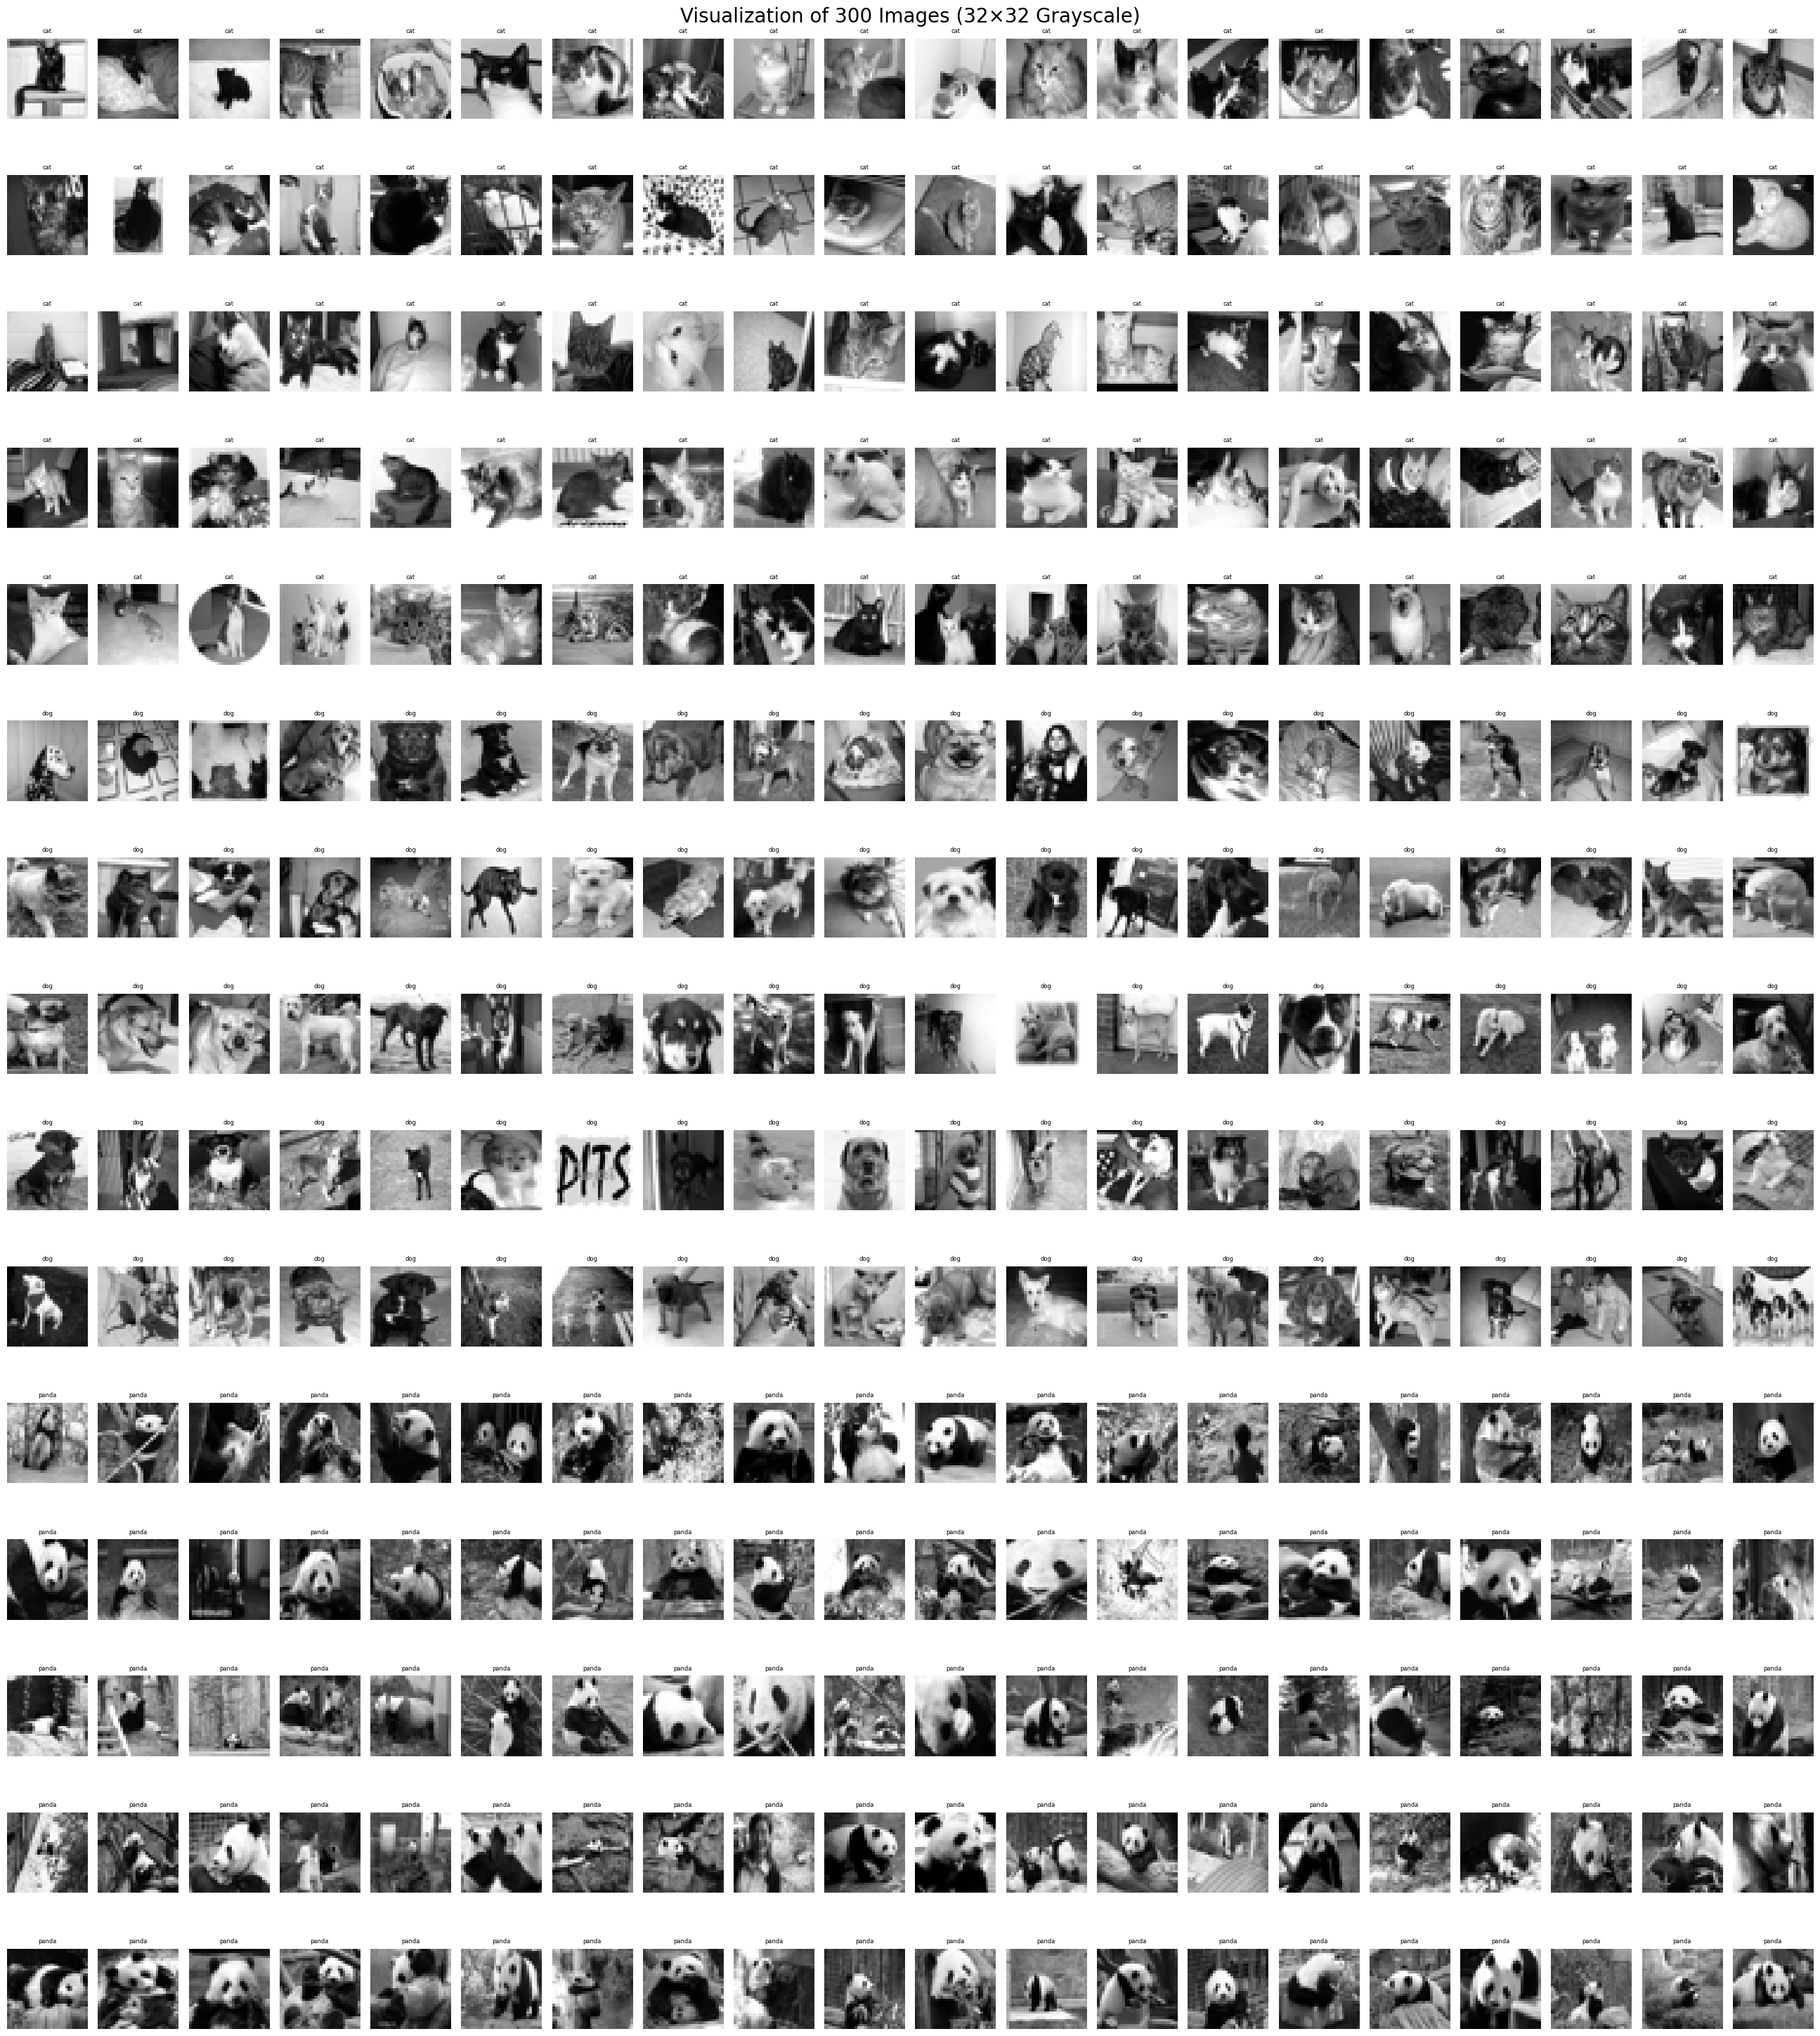

In [ ]:
plt.figure(figsize=(26, 30))
rows, cols = 15, 20

for i in range(len(X)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X[i].reshape(32,32), cmap="gray")
    plt.title(class_names[y[i]], fontsize=6)
    plt.axis("off")

plt.suptitle("Visualization of Animal Dataset Images in 32×32 Grayscale", fontsize=20)
plt.tight_layout()
plt.show()

**Normalize Pixel Values**

In [ ]:
X = X / 255.0
print("Normalization complete.")

Normalization complete.


**Initialize K-Fold Cross-Validation Setup**

In [ ]:
K_vals = list(range(1, 21))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

acc_l1, acc_l2 = [], []

**Perform Cross-Validation for L1 and L2 Distance Metrics**

In [23]:
for k in K_vals:
    model_l1 = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    model_l2 = KNeighborsClassifier(n_neighbors=k, metric="euclidean")

    acc_l1.append(cross_val_score(model_l1, X, y, cv=skf).mean() * 100)
    acc_l2.append(cross_val_score(model_l2, X, y, cv=skf).mean() * 100)

print("Cross-Validation completed.")

Cross-Validation completed.


**Plot Accuracy vs K for L1 and L2**

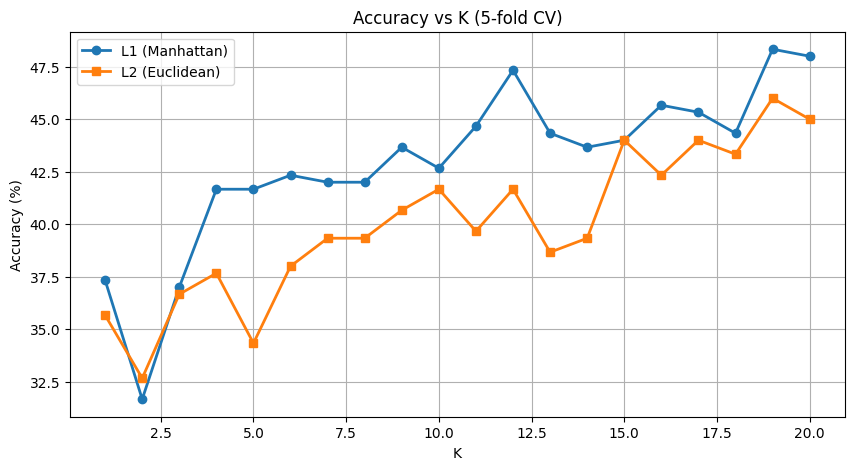

In [ ]:
plt.figure(figsize=(10,5))

# Plot L1 accuracy
plt.plot(K_vals, acc_l1, marker="o", label="L1 (Manhattan)", linewidth=2)

# Plot L2 accuracy
plt.plot(K_vals, acc_l2, marker="s", label="L2 (Euclidean)", linewidth=2)

plt.xlabel("K")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs K (5-fold CV)")
plt.grid(True)
plt.legend()
plt.show()

**Select Best Model and Evaluate on Hold-Out Test Set**

In [24]:
best_k_l1 = K_vals[np.argmax(acc_l1)]
best_k_l2 = K_vals[np.argmax(acc_l2)]

if max(acc_l1) >= max(acc_l2):
    best_metric, best_k = "manhattan", best_k_l1
else:
    best_metric, best_k = "euclidean", best_k_l2

print("Best Metric:", best_metric, "| Best K:", best_k)

X_train, X_test, y_train, y_test, fn_train, fn_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42, stratify=y
)

model = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nHold-Out Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Best Metric: manhattan | Best K: 19

Hold-Out Accuracy: 53.33%


**Generate Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

         cat       0.62      0.40      0.48        20
         dog       0.43      0.80      0.56        20
       panda       0.80      0.40      0.53        20

    accuracy                           0.53        60
   macro avg       0.62      0.53      0.53        60
weighted avg       0.62      0.53      0.53        60



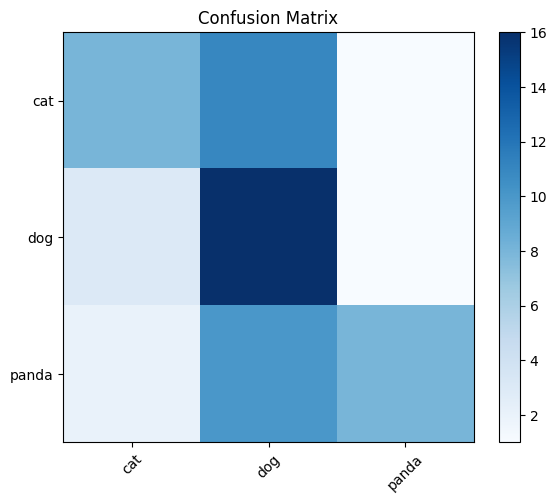

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout()
plt.show()


**Compare L1 and L2 Using Bar Chart**

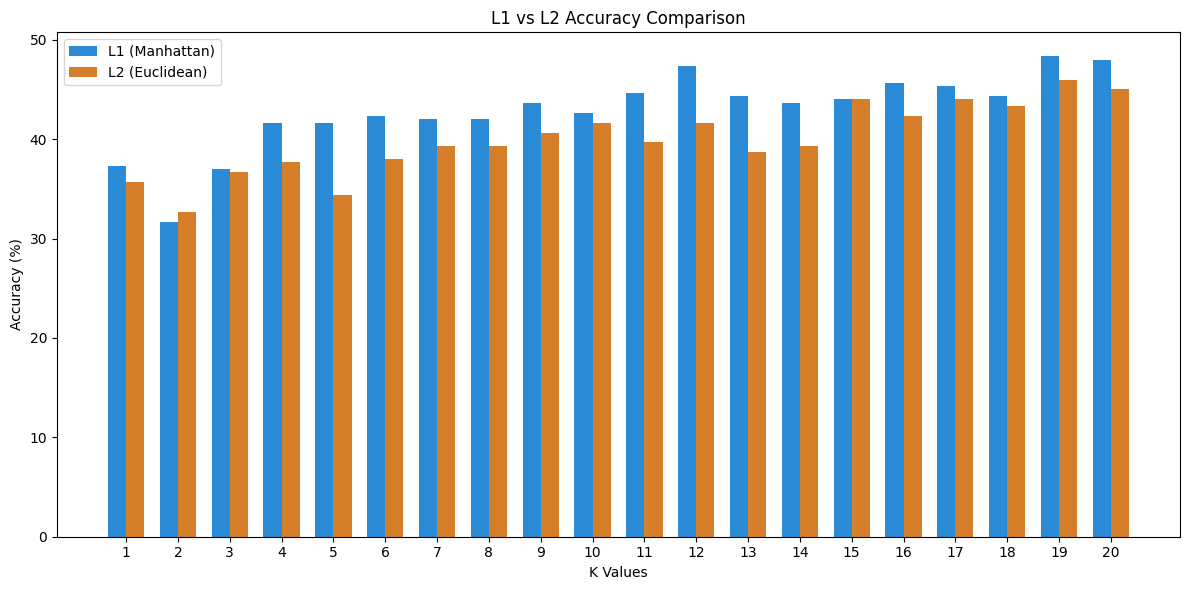

In [ ]:
plt.figure(figsize=(12,6))

x = np.arange(len(K_vals))
w = 0.35

plt.bar(x - w/2, acc_l1, w, label="L1 (Manhattan)", color="#2b8bd6")
plt.bar(x + w/2, acc_l2, w, label="L2 (Euclidean)", color="#d67f2b")

plt.xticks(x, K_vals)
plt.xlabel("K Values")
plt.ylabel("Accuracy (%)")
plt.title("L1 vs L2 Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

**Display Top 5 Predictions**

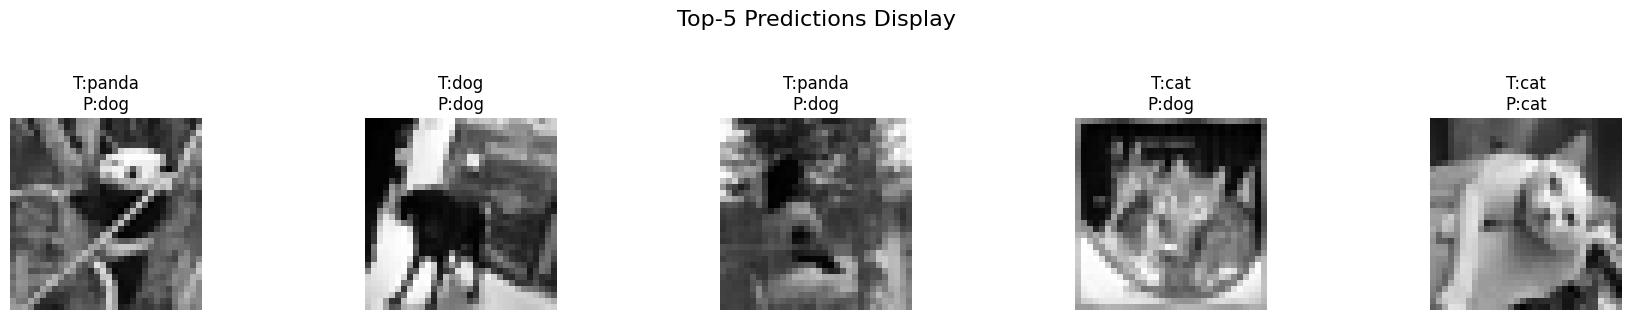

In [25]:
num_samples = 5
IMG_SIZE = 32

idxs = np.random.choice(len(X_test), size=num_samples, replace=False)

plt.figure(figsize=(18, 3))

for i, idx in enumerate(idxs):
    img = X_test[idx].reshape(IMG_SIZE, IMG_SIZE)
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{true_label}\nP:{pred_label}", fontsize=12)
    plt.axis("off")

plt.suptitle("Top-5 Predictions Display", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()